In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
0

0

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
# from networks import AdditiveNoisyNet
# from noise_generator import GaussianNoiseGenerator
# from noise_transformer import ConstantNoiseTransformer, BlockNoiseTransformer
from data import generate_data
from torch.utils.data import TensorDataset, DataLoader
# from train import Trainer

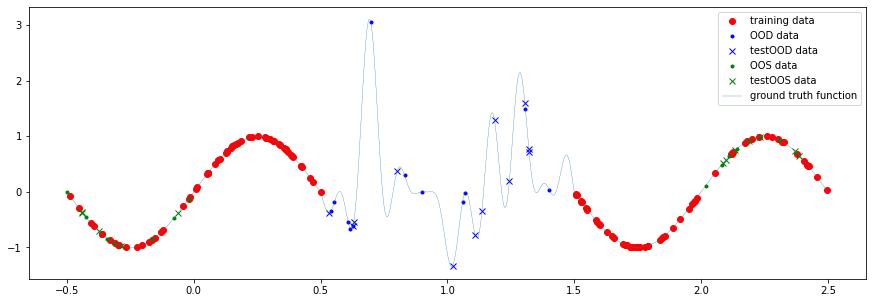

In [4]:
x, y, oos_x, oos_y, ood_x, ood_y, oos_x_test, oos_y_test, ood_x_test, ood_y_test, x_test, y_test = generate_data(plot=True,
                                                                                                                 seed=8)

In [ ]:
class Network(nn.Module):
    def __init__(self, input_dim=1, n_hidden=128):
        super().__init__()

In [14]:
def g(a):
    return torch.relu(1 + a)

class Network(nn.Module):
    def __init__(self, input_dim=1, n_hidden=128):
        super().__init__()
        self.first = nn.Linear(input_dim, n_hidden)
        self.first_noise = nn.Sequential(nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden))
        self.second = nn.Linear(n_hidden, n_hidden)
        self.second_noise = nn.Sequential(nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden))
        self.third = nn.Linear(n_hidden, n_hidden)
        self.third_noise = nn.Sequential(nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden))
        self.last = nn.Linear(n_hidden, 1)
        
    def forward(self, x, n):
        h = torch.relu(self.first(x))
        h = h * g(n[:n_hidden] * self.first_noise(h))
        h = torch.relu(self.second(h))
        h = h * g(n[n_hidden:2*n_hidden] * self.second_noise(h))
        h = torch.relu(self.third(h))
        h = h * g(n[2*n_hidden:3*n_hidden] * self.third_noise(h))
        out = self.last(h)
        return out

In [19]:
losses = []
n_hidden = 128
net = Network(n_hidden=n_hidden)
print([x for x, y in net.named_parameters() if 'noise' not in x])
epochs = 500
train_data = TensorDataset(x, y)
loader = DataLoader(train_data, shuffle=True, batch_size=64)
optimizer = torch.optim.Adam([y for x, y in net.named_parameters()], lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(epochs):
    zero_noise = torch.zeros(3 * n_hidden)
    epoch_losses = []
    for batch_id, (xi, yi) in enumerate(loader):
        noise = noise = torch.zeros(3 * n_hidden)
        optimizer.zero_grad()
        y_hat = net(xi, zero_noise)

        f_loss = loss_fn(y_hat, yi) #+ gamma * loss_fn(r_hat_1*r_hat_2, r_1*r_2)
        epoch_losses.append(f_loss.item() * xi.shape[0])
        f_loss.backward()
        optimizer.step()
    losses.append(np.sum(epoch_losses) / train_data[:][0].shape[0])

['first.weight', 'first.bias', 'second.weight', 'second.bias', 'third.weight', 'third.bias', 'last.weight', 'last.bias']


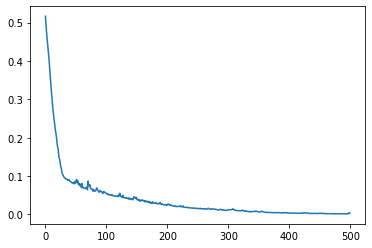

In [20]:
plt.plot(losses)

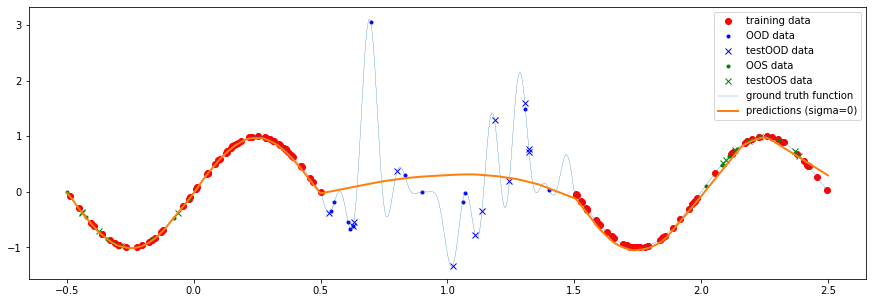

In [21]:
plt.figure(figsize=(15, 5))
plt.plot(x, y.squeeze(), 'ro', label='training data')
plt.plot(ood_x, ood_y.squeeze(), 'b.', label='OOD data')
plt.plot(ood_x_test, ood_y_test.squeeze(), 'bx', label='testOOD data')
plt.plot(oos_x, oos_y.squeeze(), 'g.', label='OOS data')
plt.plot(oos_x_test, oos_y_test.squeeze(), 'gx', label='testOOS data')
plt.plot(x_test, y_test.squeeze(), label='ground truth function', linewidth=.3)
plt.plot(x_test, net(x_test, zero_noise).detach(), linewidth=2., label='predictions (sigma=0)')
# plt.plot(x_test, torch.stack([model.sample(x_test, fixed_noise=True).detach().squeeze() for _ in range(15)], 0).mean(0),
#          label='average samples (sigma=1)')
        
plt.legend()


In [35]:
deup_losses = []
n_hidden = 128
print([x for x, y in net.named_parameters() if 'noise' not in x])
epochs = 100
oos_data = TensorDataset(torch.cat([oos_x,ood_x, x]), torch.cat([oos_y, ood_y, y]))
deup_loader = DataLoader(oos_data, shuffle=True, batch_size=64)
deup_optimizer = torch.optim.Adam([y for x, y in net.named_parameters() if 'noise' in x], lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(epochs):
    epoch_losses = []
    zero_noise = torch.zeros(3 * n_hidden)
    for batch_id, (xi, yi) in enumerate(deup_loader):
        noise = torch.randn(3 * n_hidden)
        deup_optimizer.zero_grad()
        xi_1, xi_2 = xi[:len(xi)//2], xi[len(xi)//2:]
        yi_1, yi_2 = yi[:len(yi)//2], yi[len(yi)//2:]
        mu_1 = net(xi_1, zero_noise)
        mu_2 = net(xi_2, zero_noise)
        r_hat_1 = net(xi_1, noise) - mu_1
        r_hat_2 = net(xi_2, noise) - mu_2
        r_1 = yi_1 - mu_1
        r_2 = yi_2 - mu_2
        

        f_loss = loss_fn(r_hat_1 * r_hat_1, r_1 * r_1)
        epoch_losses.append(f_loss.item() * xi.shape[0])
        f_loss.backward()
        deup_optimizer.step()
    deup_losses.append(np.sum(epoch_losses) / train_data[:][0].shape[0])

['first.weight', 'first.bias', 'second.weight', 'second.bias', 'third.weight', 'third.bias', 'last.weight', 'last.bias']


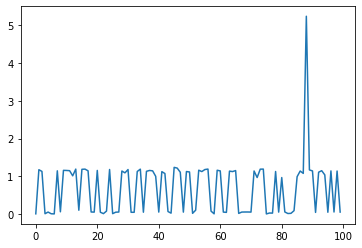

In [36]:
plt.plot(deup_losses)

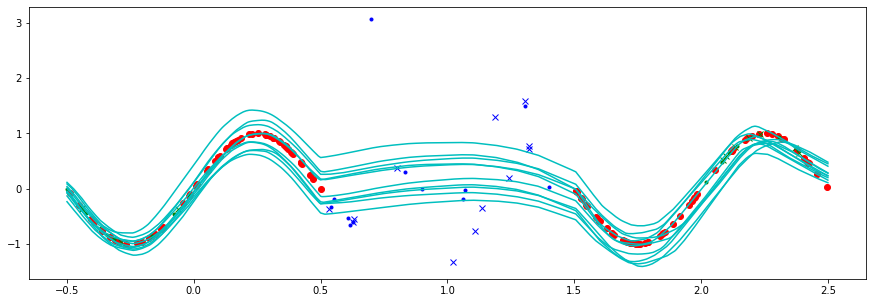

In [37]:
plt.figure(figsize=(15, 5))
plt.plot(x, y.squeeze(), 'ro', label='training data')
plt.plot(ood_x, ood_y.squeeze(), 'b.', label='OOD data')
plt.plot(ood_x_test, ood_y_test.squeeze(), 'bx', label='testOOD data')
plt.plot(oos_x, oos_y.squeeze(), 'g.', label='OOS data')
plt.plot(oos_x_test, oos_y_test.squeeze(), 'gx', label='testOOS data')
for _ in range(10):
    z = torch.randn(3 * n_hidden)
    non_dropout_pred = net(x_test, z).detach()
    plt.plot(x_test.cpu(), non_dropout_pred.cpu(), 'c')